# Group 96

In [2]:
import numpy as np
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt

## extract patches 2d

Reshape a 2D image into a collection of patches of the choosen size.
The resulting patches are allocated in a dedicated array.

## reconstruct from patches 2d

Reconstruct the image from all of its patches.
Patches are assumed to overlap and the image is constructed by filling in the patches from left to right, top to bottom, averaging the overlapping regions.

# Data Importation

In [3]:
# Importing the training patched dataset
Xtrain_a = np.load('Xtrain2_a.npy')
Ytrain_a = np.load('Ytrain2_a.npy')

# Importing the training flattened dataset
Xtrain_b = np.load('Xtrain2_b.npy')
Ytrain_b = np.load('Ytrain2_b.npy')

In [4]:
# Imbalance in the dataset a?
print('Number of samples in class 0:', np.sum(Ytrain_a == 0))
print('Number of samples in class 1:', np.sum(Ytrain_a == 1))
print("Percentage of samples in class 1: ", (np.sum(Ytrain_a == 1)/np.sum(Ytrain_a==0))*100)

# Imbalance in the dataset b?
print('Number of samples in class 0:', np.sum(Ytrain_b == 0))
print('Number of samples in class 1:', np.sum(Ytrain_b == 1))
print("Percentage of samples in class 1: ", (np.sum(Ytrain_b == 1)/np.sum(Ytrain_b==0))*100)

Number of samples in class 0: 649624
Number of samples in class 1: 315284
Percentage of samples in class 1:  48.5333054197505
Number of samples in class 0: 896429
Number of samples in class 1: 363859
Percentage of samples in class 1:  40.58982920008166


# Data Visualization

Shape of the training dataset a: 547.0


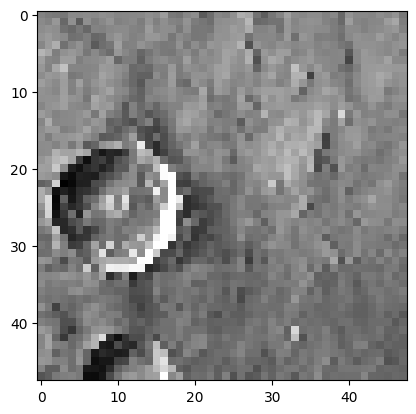

In [33]:
# Each line is a patch of 7x7 pixels
# Each image is has 1764 patchs

print('Shape of the training dataset a:', Xtrain_a.shape[0]/1764)
img_size = [48,48]
patches = np.array(Xtrain_a[0:1764])
# each patches must be a 7 by 7
patches = patches.reshape(-1, 7, 7)
img_0_a = reconstruct_from_patches_2d(patches = patches, image_size=img_size ) 
img_0_a = img_0_a.reshape(1,48,48)
plt.imshow(img_0_a[0], cmap='gray')
plt.show()


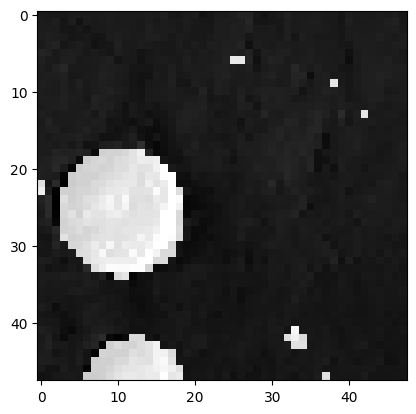

In [35]:
# Each line in the dataset b is a 2D image of 48x48 pixels
Xtrain_b_img = Xtrain_b.reshape(-1, 48, 48)
Ytrain_b_img = Ytrain_b.reshape(-1, 48,48)

# Displaying the first image and the y image
plt.imshow(Xtrain_b_img[0], cmap='gray')
plt.imshow(Ytrain_b_img[0], cmap='gray', alpha=0.8)
plt.show()